In [2]:
import os
import pandas as pd
import numpy as np
import pickle
import json
from itertools import product

from keras.models import Sequential, load_model
from keras.layers import *

from keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback

import matplotlib.pyplot as plt
plt.style.use('seaborn')

Using TensorFlow backend.


# Summary
I'm fitting the keras' embedding layer for a few epochs within the possibly simplest imaginable setup, namely with global averaging and softmax on top. This examinations in meant to be fairly inexpensive but broad, and serve to produce reasonable starting embeddings for more complicated net architectures and to compare various loss-functions/batch-sizes/optimizers. The choice of loss function is a somewhat non-trivial matter due to the class imbalance of our dataset and the stated objective of maximazing the macroF1 score.

* Results land in the directory defined in the *working_dir* variable below.
* Weights are stores as *blabla_weights.p* and they may be directly depickled into the *weights* argument of the Embedding layer (see the *Embedding* within *init* of the *BlackBox* class). 
* There are some nice plots below.

We manage to establish an interesting benchmark for our dataset: the simple setup described above is almost enough to reproduce the perfomarmance of shallow classifiers, *macroF1*=80%. For other net architectures to carry their weight, they'll have to go beyond that.

---

### Load the data in
The test data is not used

In [3]:
global_params = pickle.load(open("global_params.p", "rb"))
unique_words = global_params['unique_words']
num_words = global_params['num_words']
padded_length = global_params['padded_length']
n_classes = global_params['n_classes']
class_weights = global_params['class_weights']

global_params

{'unique_words': 277303,
 'num_words': 277304,
 'padded_length': 679,
 'n_classes': 6,
 'class_weights': array([ 1.26825655,  0.72736371,  0.27602776, 13.23801959, 30.29201502,
         9.49559404])}

In [4]:
X_train = np.load(os.path.join("data", "Kdata", "X_train.npy"))
y_train = np.load(os.path.join("data", "Kdata", "y_train.npy"))
X_val = np.load(os.path.join("data", "Kdata", "X_val.npy"))
y_val = np.load(os.path.join("data", "Kdata", "y_val.npy"))

---

## Start of boilerplate

### Some custom definitions
* metrics
* loss functions
* choice of learning parameters and settings

In [5]:
from keras import backend as K

# Custom metrics.
# Note that any metric is computed per batch during training
# (hence one needs large batches for it to make sense).
# Also, there is the implicit 0.5 treshold in the K.round function below

def macroPrec(y_true, y_pred):
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    positives = K.sum(K.round(y_pred), axis=0)
    precision = true_positives / (positives + K.epsilon())

    macroPrec = K.mean( precision )
    
    return macroPrec


def macroRecall(y_true, y_pred):
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    actual_ones = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
    recall = true_positives / (actual_ones + K.epsilon())

    macroRecall = K.mean( recall )
    
    return macroRecall


def macroF1(y_true, y_pred):

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    
    actual_ones = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
    recall = true_positives / (actual_ones + K.epsilon())

    positives = K.sum(K.round(K.clip(y_pred, 0, 1)), axis=0)
    precision = true_positives / (positives + K.epsilon())
    
    macroF1 = 2 * K.mean( precision*recall / (precision + recall + K.epsilon()) )
    
    return macroF1



# Custom loss functions
# No clippping or rounding as those are not differentiable
# Note to self: these functions are already taking into account class imbalances, so remeber
# not to set the class_weight argument in fitting method when using them as the loss 

# semi macroF1
def fuzzy_macroF1_flip(y_true, y_pred):

    true_positives = K.sum(y_true * y_pred, axis=0)
    
    actual_ones = K.sum(y_true, axis=0)
    recall = true_positives / (actual_ones + K.epsilon())

    positives = K.sum(y_pred, axis=0)
    precision = true_positives / (positives + K.epsilon())
    
    macroF1 = 2 * K.mean( precision*recall / (precision + recall + K.epsilon()) ) 
    
    return 1-macroF1


# weighted categorical crossentropy
def my_crossE(y_true, y_pred):
    
    class_entropy = K.sum(y_true * K.log(y_pred+K.epsilon()), axis=0)
    weighted_entropy = K.mean(class_weights * class_entropy)
    return -4E-4 * weighted_entropy  # arbitrary coefficient to make it close to [0-1] interval


# take average of the last two, because why not
def my_loss(y_true, y_pred):
    # return 0.5*(fuzzy_macroF1_flip(y_true, y_pred) + my_crossE(y_true, y_pred))
    
    true_positives = K.sum(y_true * y_pred, axis=0)
    
    actual_ones = K.sum(y_true, axis=0)
    recall = true_positives / (actual_ones + K.epsilon())

    positives = K.sum(y_pred, axis=0)
    precision = true_positives / (positives + K.epsilon())
    
    macroF1p2 = K.mean( precision*recall / (precision + recall + K.epsilon()) )
    
    class_entropy = K.sum(y_true * K.log(y_pred+K.epsilon()), axis=0)
    weighted_entropy = K.mean(class_weights * class_entropy)
    
    return 0.5 - macroF1p2 - 2E-4 * weighted_entropy

In [6]:
my_metrics = [macroPrec, macroF1, macroRecall] #, my_crossE, fuzzy_macroF1_flip, my_loss]

custom_objects={'macroPrec': macroPrec,\
                'macroF1': macroF1,\
                'macroRecall': macroRecall,\
                'my_crossE': my_crossE,\
                'fuzzy_macroF1_flip': fuzzy_macroF1_flip,\
                'my_loss': my_loss
               }

In [7]:
# auxiliary function
# to plot the learning history,
# i.e. loss and metrics on each train_batch and validation_batch
def plot_history(history, with_lr=False):
    
    n_plots = 3 if with_lr else 2
    plt.figure(figsize=(6*n_plots, 5))
    
    loss = history['loss']
    val_loss = history['val_loss']
    x = range(1, len(loss) + 1)
    
    plt.subplot(1, n_plots, 1)    
    plt.plot(x, loss, 'ob', label='Training loss')
    plt.plot(x, val_loss, '-b', label='Validation loss')
    plt.title('Training and val losses') 
    plt.legend()
    
    all_metrics = np.array(list(set(history.keys()) - set(['loss', 'val_loss', 'lr'])))
    metrics = all_metrics[[not metric.startswith('val_') for metric in all_metrics]]
    plt.subplot(1, n_plots, 2)
    markers = ['b', 'r',  'g', 'y', 'm', 'c', 'k']
    marker = zip(markers, markers)
    for metric in metrics:
        results = history[metric]
        val_results = history['val_'+metric]
        mark1, mark2 = next(marker)
        plt.plot(x, results, 'o'+mark1, label=metric)
        plt.plot(x, val_results, '-'+mark2, label='Validation '+metric)
        plt.title('Training and val metrics')
    plt.legend()
    
    if with_lr:
        plt.subplot(1, 3, 3)
        lr = history['lr'] # learning rate
        plt.plot(x, lr, 'k', label='Learning rate')
        plt.title('Learning rate')  
        plt.legend()
    

### Define a wrapper class for creating the classification model with embedding, fitting, etc.
It creates an useful object using a list of intermediate layers as the main argument.
Makes it easier to consistently use the chosen metrics, loss function, class_weights, embedding etc.

In [8]:
working_dir = "simple_tests_2"
! mkdir simple_tests_2

A subdirectory or file simple_tests_2 already exists.


In [22]:
# the workhorse
class BlackBox():
    
    def __init__(self, layers, loss, batch_size, optimizer, epochs,\
                 metrics=my_metrics,\
                 verbose=0,\
                 callbacks=None,\
                 embedd = None, embedd_dims=[None]*3, train_weights=True,\
                 mask_zeros=True
                ):
        
        self.layers = layers
        self.loss = loss
        self.loss_name = self.loss.__name__ if self.loss != 'categorical_crossentropy' else 'cat-cross'
        self.batch_size = batch_size
        self.epochs = epochs
        self.optimizer = optimizer
        self.metrics = metrics
        self.verbose = verbose
        self.callbacks = callbacks
        if loss == 'categorical_crossentropy':
            self.class_weight = class_weights
        else:
            self.class_weight = None
        self.train_weigts = train_weights
        self.mask_zeros = mask_zeros
        
        self.history = None
        self.test_results = None
        self.val_score = None
                
        self.model = Sequential()
        if embedd:
            self.input_dim = embedd_dims[0] # num_words
            self.output_dim = embedd_dims[1] # dimension of the embedding space
            self.input_length = embedd_dims[2] # padded_length
            with open(embedd, "rb") as f:
                self.embedd_weights = pickle.load(f)
            
            self.model.add(Embedding(input_dim=self.input_dim,\
                                     output_dim=self.output_dim,\
                                     input_length=self.input_length,\
                                     weights=self.embedd_weights,\
                                     trainable=self.train_weigts,\
                                     mask_zero=self.mask_zeros))
            self.model.layers[0].trainable = self.train_weigts  # szczeżonego panbug szczeże
            
        for layer in layers:
            self.model.add(layer)
            
        self.model.add(Dense(n_classes, activation='softmax'))
        self.model.compile(loss=self.loss, optimizer=self.optimizer, metrics=self.metrics)
        
        self.name = f"{self.loss_name}_batch{self.batch_size}_{self.optimizer}"
        self.describe = f"loss={self.loss_name}, batch_size={self.batch_size}, optimizer={self.optimizer}, explicit-class-weights: {type(self.class_weight)==np.ndarray}, embedd-trainable: {self.model.layers[0].trainable}"

    
    def summary(self):
        print(self.describe)
        return self.model.summary()
    
    def fit(self):
        print(self.describe)
              
        self.history = self.model.fit(
            X_train, y_train,
            class_weight=self.class_weight,
            epochs=self.epochs,
            batch_size=self.batch_size,
            #validation_split=0.1,
            validation_data=(X_val, y_val),
            callbacks=self.callbacks,
            verbose = self.verbose        
            ).history
        self.val_score = self.history['val_macroF1'][-1]
        print(f"Last val_macroF1: {self.val_score}")

        
    def evaluate(self, X_test, y_test):
        
        print(f'Loss function: {self.loss_name}. Metrics: {[metric.__name__ if callable(metric) else metric for metric in self.metrics]}')
        print("Predicting for X_test, comparing with y_test")
        return self.model.evaluate(X_test, y_test)
    
    def plot(self, with_lr=False, from_file=False):
        print(self.describe)
        try:
            if not from_file:
                plot_history(self.history, with_lr=with_lr)
            else:
                hist = json.load(open(os.path.join(working_dir, f"{self.name}_history.p"), "r"))
                plot_history(hist, with_lr=with_lr)
        except:
            print("nope!")
        
    def save_embedd(self):
        file = os.path.join(working_dir, f"{self.name}_weights.p")
        with open(file, 'wb') as f:
            pickle.dump(self.model.layers[0].get_weights(), f)
        
    def Ksave(self):
        file = os.path.join(working_dir, f"{self.name}_Kmodel.h5")
        self.model.save(file)
        
    def discard(self):
        self.model = None
    
    def save_hist(self):
        file = os.path.join(working_dir, f"{self.name}_history.p")
        with open(file, 'w') as f:
            json.dump(self.history, f)


In [23]:
# # choose callbacks to be given in model.fit(...)


# # If the embedding layer is given to BlackBox from a file
# # and it is set to not be trainable,
# # it may yet be unfrozen by a callback piggybacking on the ReducLROnPlateau callback

# class WakeEmbedding(Callback):
    
#     def __init__(self, rel_lr_treshold):
#         self.rel_lr_treshold = rel_lr_treshold
    
#     def on_train_begin(self, logs={}):
#         self.init_lr =  K.eval(self.model.optimizer.lr)
        
#     def on_epoch_begin(self, epoch, logs={}):
#         lr =  K.eval(self.model.optimizer.lr)
#         if (lr / self.init_lr) <= self.rel_lr_treshold:
#             self.model.layers[0].trainable = True
#         print("Embedding trainable:", self.model.layers[0].trainable)

        
# # the early-stopping is monitoring the batchwise-macroF1 (which is risky)

# def callbacks(plateau_factor=0.1, plateau_patience=1,\
#               early_s_patience = 2,\
#               wake_embedd=False, wake_treshold = 0.1
#              ):
    
#     callbacks = [ReduceLROnPlateau(factor=plateau_factor,\
#                                    monitor='val_macroF1', mode='max', patience = plateau_patience),
#                 EarlyStopping(monitor='val_macroF1', mode='max', patience=early_s_patience)
#                ]
    
#     return callbacks + [WakeEmbedding(wake_treshold)] if wake_embedd else callbacks


## End of boilerplate

---
---

# Quasi-grid-search that optimizes the BlackBox
* Define the sequential setup by specifiying the layers, and parameter scopes to search through.
* Train for a fixed number of epochs.
* Examine how different parameter combinations influence quality of the classification (measured by the resulting model's macro-F1 on the validation set).

---

In [24]:
layers = [Embedding(input_dim=num_words, output_dim=50, input_length=padded_length, mask_zero=True),
          Dropout(0.3),
          GlobalAveragePooling1D()
         ]

In [25]:
losses = ['categorical_crossentropy', fuzzy_macroF1_flip, my_loss]
batch_sizes = [300, 500, 800, 1300]
optimizers = ['adamax', 'adam', 'nadam']

options = list(product(losses, batch_sizes, optimizers))
n_options = len(options)
print(f"{n_options} options in the cross-search, e.g. {options[0]}")

36 options in the cross-search, e.g. ('categorical_crossentropy', 300, 'adamax')


---

In [26]:
# # A single test, e.g.

# k = 0

# loss, batch_size, optimizer = options[k]
# print(f"Option {k+1}/{n_options}")

# model = BlackBox(layers=layers, loss=loss, batch_size=batch_size, optimizer=optimizer, epochs=1, verbose=1)
# model.summary()
# model.fit()

# model.save_embedd()
# model.Ksave()
# model.save_hist()
# model.discard()

# model.plot()

In [27]:
# model.val_score, k, model.loss_name, model.batch_size, model.optimizer

---

In [28]:
# run in a loop

epochs = 1
results = {}

def run_test(k):

    loss, batch_size, optimizer = options[k]
    print(f"\n{k+1}/{n_options}")    

    model = BlackBox(layers=layers, loss=loss, batch_size=batch_size, optimizer=optimizer, epochs=epochs, verbose=1)
    model.fit()
    model.discard()
     
    results[k] = model

    
for k in range(n_options):
    run_test(k)


1/36
loss=categorical_crossentropy, batch_size=300, optimizer=adamax, explicit-class-weights: True, embedd-trainable: True
Train on 500000 samples, validate on 200000 samples
Epoch 1/1
500000/500000 [==============================] - 610s 1ms/step - loss: 0.5099 - macroPrec: 0.3806 - macroF1: 0.3525 - macroRecall: 0.3438 - val_loss: 0.3030 - val_macroPrec: 0.4450 - val_macroF1: 0.4412 - val_macroRecall: 0.4385
Last val_macroF1: 0.4412118990123272

2/36
loss=categorical_crossentropy, batch_size=300, optimizer=adam, explicit-class-weights: True, embedd-trainable: True
Train on 500000 samples, validate on 200000 samples
Epoch 1/1
500000/500000 [==============================] - 635s 1ms/step - loss: 0.4375 - macroPrec: 0.4149 - macroF1: 0.3867 - macroRecall: 0.3751 - val_loss: 0.2627 - val_macroPrec: 0.4606 - val_macroF1: 0.4515 - val_macroRecall: 0.4467
Last val_macroF1: 0.4515499181300402

3/36
loss=categorical_crossentropy, batch_size=300, optimizer=nadam, explicit-class-weights: True

Train on 500000 samples, validate on 200000 samples
Epoch 1/1
500000/500000 [==============================] - 413s 825us/step - loss: 0.3711 - macroPrec: 0.7493 - macroF1: 0.6718 - macroRecall: 0.6423 - val_loss: 0.2719 - val_macroPrec: 0.8069 - val_macroF1: 0.7655 - val_macroRecall: 0.7476
Last val_macroF1: 0.7654735436439514

20/36
loss=fuzzy_macroF1_flip, batch_size=800, optimizer=adam, explicit-class-weights: False, embedd-trainable: True
Train on 500000 samples, validate on 200000 samples
Epoch 1/1
500000/500000 [==============================] - 426s 851us/step - loss: 0.3860 - macroPrec: 0.7505 - macroF1: 0.6590 - macroRecall: 0.6254 - val_loss: 0.2684 - val_macroPrec: 0.8054 - val_macroF1: 0.7699 - val_macroRecall: 0.7548
Last val_macroF1: 0.7698554668426514

21/36
loss=fuzzy_macroF1_flip, batch_size=800, optimizer=nadam, explicit-class-weights: False, embedd-trainable: True
Train on 500000 samples, validate on 200000 samples
Epoch 1/1
500000/500000 [==========================

In [39]:
results_list = [(k+1, model.val_score, model.loss_name, model.batch_size, model.optimizer) for (k, model) in results.items()]
ranking_list = sorted(results_list, key=lambda item: item[1], reverse = True)

In [40]:
ranking_list

[(33, 0.7883273792266846, 'my_loss', 800, 'nadam'),
 (36, 0.7877453363239765, 'my_loss', 1300, 'nadam'),
 (32, 0.7834563896656036, 'my_loss', 800, 'adam'),
 (35, 0.7826843253076077, 'my_loss', 1300, 'adam'),
 (34, 0.7820526918172837, 'my_loss', 1300, 'adamax'),
 (31, 0.7817738289833069, 'my_loss', 800, 'adamax'),
 (21, 0.7810611670017242, 'fuzzy_macroF1_flip', 800, 'nadam'),
 (30, 0.7804499100148677, 'my_loss', 500, 'nadam'),
 (24, 0.7793939271271229, 'fuzzy_macroF1_flip', 1300, 'nadam'),
 (29, 0.7751490314304829, 'my_loss', 500, 'adam'),
 (28, 0.7722386835515499, 'my_loss', 500, 'adamax'),
 (18, 0.7708858877420426, 'fuzzy_macroF1_flip', 500, 'nadam'),
 (20, 0.7698554668426514, 'fuzzy_macroF1_flip', 800, 'adam'),
 (22, 0.7688893550634384, 'fuzzy_macroF1_flip', 1300, 'adamax'),
 (23, 0.7677173560261726, 'fuzzy_macroF1_flip', 1300, 'adam'),
 (19, 0.7654735436439514, 'fuzzy_macroF1_flip', 800, 'adamax'),
 (17, 0.7615042695403099, 'fuzzy_macroF1_flip', 500, 'adam'),
 (27, 0.758785068303346

In [41]:
working_dir = "keras_GS_results"
! mkdir keras_GS_results

A subdirectory or file keras_GS_results already exists.


loss=my_loss, batch_size=800, optimizer=nadam, explicit-class-weights: False, embedd-trainable: True
Train on 500000 samples, validate on 200000 samples
Epoch 1/5
500000/500000 [==============================] - 475s 949us/step - loss: 0.1581 - macroPrec: 0.7872 - macroF1: 0.7604 - macroRecall: 0.7574 - val_loss: 0.1340 - val_macroPrec: 0.7910 - val_macroF1: 0.7895 - val_macroRecall: 0.8036
Epoch 2/5
500000/500000 [==============================] - 464s 928us/step - loss: 0.1128 - macroPrec: 0.8204 - macroF1: 0.8274 - macroRecall: 0.8472 - val_loss: 0.1303 - val_macroPrec: 0.7877 - val_macroF1: 0.7936 - val_macroRecall: 0.8154
Epoch 3/5
500000/500000 [==============================] - 460s 920us/step - loss: 0.1090 - macroPrec: 0.8217 - macroF1: 0.8319 - macroRecall: 0.8553 - val_loss: 0.1291 - val_macroPrec: 0.7883 - val_macroF1: 0.7952 - val_macroRecall: 0.8172
Epoch 4/5
500000/500000 [==============================] - 474s 948us/step - loss: 0.1064 - macroPrec: 0.8246 - macroF1: 0.8

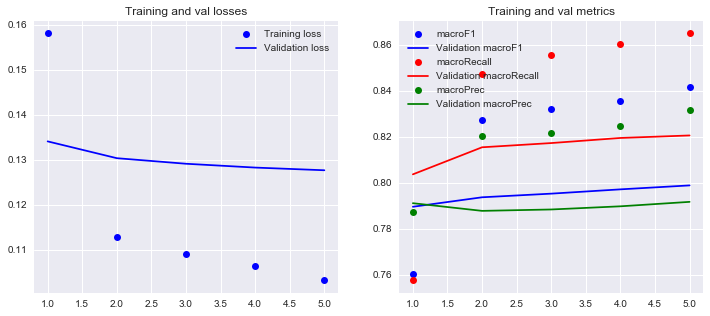

In [46]:
place=0

k, *_ = ranking_list[place]
loss, batch_size, optimizer = options[k-1]

model = BlackBox(layers=layers, loss=loss, batch_size=batch_size, optimizer=optimizer, epochs=5, verbose=1)
model.fit()
model.save_embedd()
model.Ksave()
model.save_hist()
model.discard()
model.plot()

loss=categorical_crossentropy, batch_size=500, optimizer=nadam, explicit-class-weights: True, embedd-trainable: True
Train on 500000 samples, validate on 200000 samples
Epoch 1/5
500000/500000 [==============================] - 589s 1ms/step - loss: 0.2156 - macroPrec: 0.7903 - macroF1: 0.7089 - macroRecall: 0.6762 - val_loss: 0.1957 - val_macroPrec: 0.8226 - val_macroF1: 0.7565 - val_macroRecall: 0.7279
Epoch 2/5
500000/500000 [==============================] - 579s 1ms/step - loss: 0.1752 - macroPrec: 0.8558 - macroF1: 0.8049 - macroRecall: 0.7820 - val_loss: 0.1909 - val_macroPrec: 0.8236 - val_macroF1: 0.7630 - val_macroRecall: 0.7369
Epoch 3/5
500000/500000 [==============================] - 566s 1ms/step - loss: 0.1683 - macroPrec: 0.8642 - macroF1: 0.8163 - macroRecall: 0.7952 - val_loss: 0.1883 - val_macroPrec: 0.8207 - val_macroF1: 0.7673 - val_macroRecall: 0.7440
Epoch 4/5
500000/500000 [==============================] - 563s 1ms/step - loss: 0.1626 - macroPrec: 0.8655 - macr

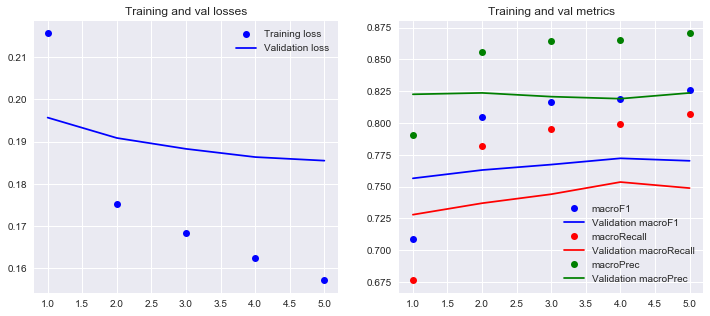

In [47]:
loss, batch_size, optimizer = 'categorical_crossentropy', 500, 'nadam'

model2 = BlackBox(layers=layers, loss=loss, batch_size=batch_size, optimizer=optimizer, epochs=5, verbose=1)
model2.fit()
model2.save_embedd
model2.Ksave()
model2.save_hist()
model2.discard()
model2.plot()

In [54]:
loss, batch_size, optimizer = 'categorical_crossentropy', 500, 'nadam'

model2 = BlackBox(layers=layers, loss=loss, batch_size=batch_size, optimizer=optimizer, epochs=5, verbose=1)
model2.fit()
model2.save_embedd
model2.Ksave()
model2.save_hist()
model2.discard()
model2.plot()

loss=categorical_crossentropy, batch_size=500, optimizer=nadam, explicit-class-weights: True, embedd-trainable: True
Train on 500000 samples, validate on 200000 samples
Epoch 1/5
500000/500000 [==============================] - 557s 1ms/step - loss: 0.2178 - macroPrec: 0.7983 - macroF1: 0.7119 - macroRecall: 0.6761 - val_loss: 0.1894 - val_macroPrec: 0.8252 - val_macroF1: 0.7610 - val_macroRecall: 0.7326
Epoch 2/5
500000/500000 [==============================] - 551s 1ms/step - loss: 0.1612 - macroPrec: 0.8660 - macroF1: 0.8201 - macroRecall: 0.7991 - val_loss: 0.1858 - val_macroPrec: 0.8243 - val_macroF1: 0.7688 - val_macroRecall: 0.7455
Epoch 3/5
 54500/500000 [==>...........................] - ETA: 7:57 - loss: 0.1539 - macroPrec: 0.8728 - macroF1: 0.8350 - macroRecall: 0.8188

KeyboardInterrupt: 

---
---

## Training a keras-layer embedding
### (naively, not CBOW or skipgram)
* using only global-average-pooling before softmax
* training for a fixed, short number of epochs: the goal is not to train the dense classification layer but to pretrain the embedding
* mask zeros in input
* use class_weights with default keras loss functions
* do not use class_weights with fuzzy_macroF1 or my_crossE
* save weights to files
* see which loss function got the best val_macroF1 at the last epoch

### loss=*categorical_crossentropy*, class_weight

In [21]:
# dimension of the embedding space = output_dim

layers1 = [Embedding(input_dim=num_words, output_dim=50, input_length=padded_length, mask_zero=True),
           GlobalAveragePooling1D()]

model1 = BlackBox(layers=layers1, loss='categorical_crossentropy', class_weight=class_weights, metrics=my_metrics)
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 679, 50)           13865200  
_________________________________________________________________
global_average_pooling1d_2 ( (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 306       
Total params: 13,865,506
Trainable params: 13,865,506
Non-trainable params: 0
_________________________________________________________________


In [22]:
model1.fit() # batch_size=200

Train on 500000 samples, validate on 200000 samples
Epoch 1/10
500000/500000 [==============================] - 938s 2ms/step - loss: 0.3990 - macroPrec: 0.4242 - macroF1: 0.4030 - macroRecall: 0.3952 - val_loss: 0.2286 - val_macroPrec: 0.5334 - val_macroF1: 0.4942 - val_macroRecall: 0.4807
Epoch 2/10
500000/500000 [==============================] - 1073s 2ms/step - loss: 0.1983 - macroPrec: 0.6673 - macroF1: 0.6019 - macroRecall: 0.5775 - val_loss: 0.1935 - val_macroPrec: 0.7296 - val_macroF1: 0.6666 - val_macroRecall: 0.6438
Epoch 3/10
500000/500000 [==============================] - 875s 2ms/step - loss: 0.1686 - macroPrec: 0.7617 - macroF1: 0.7071 - macroRecall: 0.6878 - val_loss: 0.1851 - val_macroPrec: 0.7532 - val_macroF1: 0.7006 - val_macroRecall: 0.6833
Epoch 4/10
500000/500000 [==============================] - 650s 1ms/step - loss: 0.1524 - macroPrec: 0.7869 - macroF1: 0.7401 - macroRecall: 0.7250 - val_loss: 0.1822 - val_macroPrec: 0.7607 - val_macroF1: 0.7142 - val_macroRe

KeyboardInterrupt: 

In [15]:
model1.fit() # batch_size=500

Train on 500000 samples, validate on 200000 samples
Epoch 1/10
500000/500000 [==============================] - 427s 853us/step - loss: 0.5665 - macroPrec: 0.3705 - macroF1: 0.3378 - macroRecall: 0.3264 - val_loss: 0.2873 - val_macroPrec: 0.4508 - val_macroF1: 0.4466 - val_macroRecall: 0.4430
Epoch 2/10
500000/500000 [==============================] - 463s 926us/step - loss: 0.2470 - macroPrec: 0.5027 - macroF1: 0.4689 - macroRecall: 0.4600 - val_loss: 0.2251 - val_macroPrec: 0.6133 - val_macroF1: 0.5140 - val_macroRecall: 0.4918
Epoch 3/10
500000/500000 [==============================] - 490s 981us/step - loss: 0.2015 - macroPrec: 0.7088 - macroF1: 0.5896 - macroRecall: 0.5519 - val_loss: 0.2018 - val_macroPrec: 0.7685 - val_macroF1: 0.6446 - val_macroRecall: 0.6003
Epoch 4/10
500000/500000 [==============================] - 498s 995us/step - loss: 0.1782 - macroPrec: 0.8220 - macroF1: 0.7109 - macroRecall: 0.6646 - val_loss: 0.1911 - val_macroPrec: 0.8153 - val_macroF1: 0.7166 - val_

In [14]:
model1.fit() # batch_size=3000

Train on 500000 samples, validate on 200000 samples
Epoch 1/10
500000/500000 [==============================] - 376s 752us/step - loss: 1.2462 - macroPrec: 0.0799 - macroF1: 0.0651 - macroRecall: 0.0673 - val_loss: 0.8324 - val_macroPrec: 0.3054 - val_macroF1: 0.1558 - val_macroRecall: 0.1668
Epoch 2/10
500000/500000 [==============================] - 385s 770us/step - loss: 0.6297 - macroPrec: 0.3990 - macroF1: 0.2788 - macroRecall: 0.2583 - val_loss: 0.4733 - val_macroPrec: 0.4670 - val_macroF1: 0.3881 - val_macroRecall: 0.3508
Epoch 3/10
500000/500000 [==============================] - 381s 762us/step - loss: 0.4003 - macroPrec: 0.4579 - macroF1: 0.4231 - macroRecall: 0.3991 - val_loss: 0.3513 - val_macroPrec: 0.4526 - val_macroF1: 0.4371 - val_macroRecall: 0.4232
Epoch 4/10
500000/500000 [==============================] - 380s 760us/step - loss: 0.3222 - macroPrec: 0.4526 - macroF1: 0.4423 - macroRecall: 0.4327 - val_loss: 0.3027 - val_macroPrec: 0.4525 - val_macroF1: 0.4450 - val_

In [16]:
name = f"50dim_GlblAvg_CatCrossE_{epochs}epochs"
model1.save_embedd(name)
model1.Ksave(name)
model1.save_hist(name)

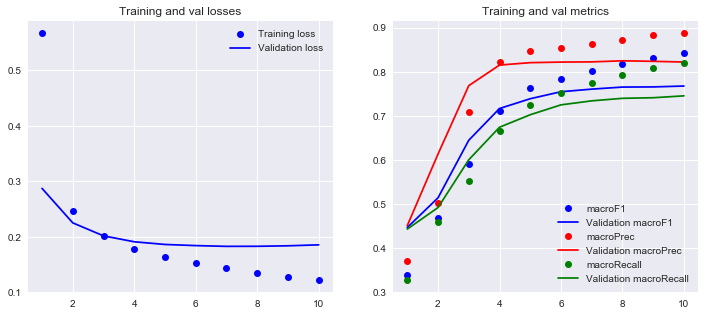

In [17]:
model1.plot()

### Comment
For all measurements the results on test and validation data were very close.
At first the macro precision, recall and F1 (per batch) rose together and plateaued around 0.45 for about four epochs. Then the precision picked up visibly but the recall was much slower to pick up, and consequently the final F1 after 10 epoch had reached a meager 0.60%.

In [17]:
# # the history may be loaded from file and played with later 
# hist = json.load(open(os.path.join("my_embeddings", "history_of_50dim_GlblAvg_CatCrossE_10epochs.p"), "r"))
# plot_history(hist)

---

### loss=*fuzzy_macroF1_flip*, class_weight=*None*

In [18]:
layers2 = [Embedding(input_dim=num_words, output_dim=50, input_length=padded_length, mask_zero=True),
           GlobalAveragePooling1D()]

model2 = BlackBox(layers=layers2, loss=fuzzy_macroF1_flip, class_weight=None, metrics=my_metrics)
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 679, 50)           13865200  
_________________________________________________________________
global_average_pooling1d_3 ( (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 306       
Total params: 13,865,506
Trainable params: 13,865,506
Non-trainable params: 0
_________________________________________________________________


In [19]:
model2.fit()

Train on 500000 samples, validate on 200000 samples
Epoch 1/10
500000/500000 [==============================] - 381s 762us/step - loss: 0.8385 - macroPrec: 0.0905 - macroF1: 0.0593 - macroRecall: 0.0573 - val_loss: 0.7678 - val_macroPrec: 0.3185 - val_macroF1: 0.1842 - val_macroRecall: 0.1753
Epoch 2/10
500000/500000 [==============================] - 381s 762us/step - loss: 0.6736 - macroPrec: 0.4316 - macroF1: 0.3548 - macroRecall: 0.3281 - val_loss: 0.6005 - val_macroPrec: 0.4414 - val_macroF1: 0.4290 - val_macroRecall: 0.4176
Epoch 3/10
500000/500000 [==============================] - 425s 850us/step - loss: 0.5587 - macroPrec: 0.4945 - macroF1: 0.4449 - macroRecall: 0.4339 - val_loss: 0.5172 - val_macroPrec: 0.5597 - val_macroF1: 0.4856 - val_macroRecall: 0.4628
Epoch 4/10
500000/500000 [==============================] - 403s 805us/step - loss: 0.4638 - macroPrec: 0.6996 - macroF1: 0.5553 - macroRecall: 0.5200 - val_loss: 0.4103 - val_macroPrec: 0.8509 - val_macroF1: 0.6500 - val_

In [20]:
name = f"50dim_GlblAvg_F1flip_{epochs}epochs"
model2.save_embedd(name)
model2.Ksave(name)
model2.save_hist(name)

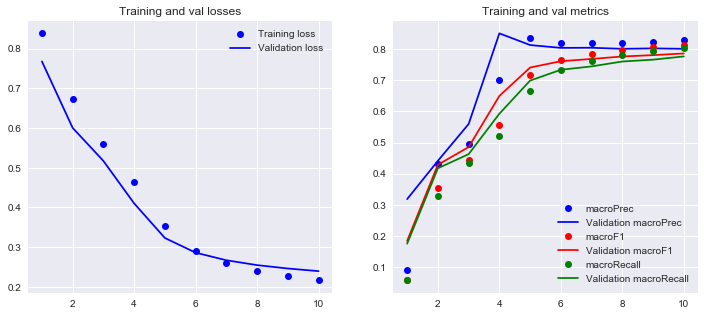

In [21]:
model2.plot()

### Comment
Again the validation data followed the test data during the 10 epochs. This time there is no notable plateau of the three metrics, precision/recall/F1, around 0.45. They comfortably rise together up to about 0.79% and stay there at practically the same value.

In [22]:
# # the history may be loaded from file and played with later 
# hist = json.load(open(os.path.join("my_embeddings", "history_of_50dim_GlblAvg_CatCrossE_10epochs.p"), "r"))
# plot_history(hist)

---

### loss=*my_crossE*, class_weight=*None*

In [23]:
# dimension of the embedding space, output_dim
# custom loss_2

layers3 = [Embedding(input_dim=num_words, output_dim=50, input_length=padded_length, mask_zero=True),
           GlobalAveragePooling1D()]

model3 = BlackBox(layers=layers3, loss=my_crossE, class_weight=None, metrics=my_metrics)
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 679, 50)           13865200  
_________________________________________________________________
global_average_pooling1d_4 ( (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 306       
Total params: 13,865,506
Trainable params: 13,865,506
Non-trainable params: 0
_________________________________________________________________


In [24]:
model3.fit()

Train on 500000 samples, validate on 200000 samples
Epoch 1/10
500000/500000 [==============================] - 381s 762us/step - loss: 0.3309 - macroPrec: 0.0311 - macroF1: 6.6715e-04 - macroRecall: 3.4139e-04 - val_loss: 0.2848 - val_macroPrec: 0.2997 - val_macroF1: 0.0142 - val_macroRecall: 0.0074
Epoch 2/10
500000/500000 [==============================] - 379s 758us/step - loss: 0.2291 - macroPrec: 0.5606 - macroF1: 0.2101 - macroRecall: 0.1514 - val_loss: 0.1796 - val_macroPrec: 0.8687 - val_macroF1: 0.4651 - val_macroRecall: 0.3530
Epoch 3/10
500000/500000 [==============================] - 381s 762us/step - loss: 0.1472 - macroPrec: 0.8192 - macroF1: 0.6275 - macroRecall: 0.5403 - val_loss: 0.1257 - val_macroPrec: 0.7606 - val_macroF1: 0.6904 - val_macroRecall: 0.6535
Epoch 4/10
500000/500000 [==============================] - 381s 763us/step - loss: 0.1085 - macroPrec: 0.7512 - macroF1: 0.7242 - macroRecall: 0.7279 - val_loss: 0.1018 - val_macroPrec: 0.7288 - val_macroF1: 0.724

In [25]:
name = f"50dim_GlblAvg_MyCrossE_{epochs}epochs"
model3.save_embedd(name)
model3.Ksave(name)
model3.save_hist(name)

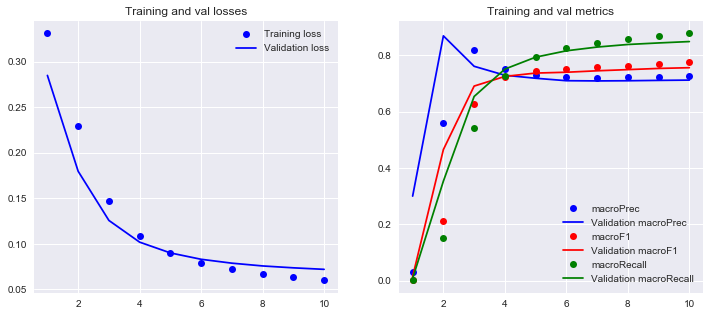

In [26]:
model3.plot()

### Comment
This loss function (*my_crossE*) puts larger emphasis on misclassified records - via *log*, like the usual crossentropy - so that recall is prioritized over precision and those are now in reversed order. The macro F1 raises monotonically up to 0.76% which is over two points less than the previous loss function (*fuzzy_macroF1_flip*).

In [27]:
# # the history may be loaded from file and played with later 
# hist = json.load(open(os.path.join("my_embeddings", "history_of_50dim_GlblAvg_CatCrossE_10epochs.p"), "r"))
# plot_history(hist)

---

### loss=*my_loss*, class_weight=*None*

In [28]:
# dimension of the embedding space, output_dim
# custom loss_3

layers4 = [Embedding(input_dim=num_words, output_dim=50, input_length=padded_length, mask_zero=True),
           GlobalAveragePooling1D()]

model4 = BlackBox(layers=layers4, loss=my_loss, class_weight=None, metrics=my_metrics)
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 679, 50)           13865200  
_________________________________________________________________
global_average_pooling1d_5 ( (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 306       
Total params: 13,865,506
Trainable params: 13,865,506
Non-trainable params: 0
_________________________________________________________________


In [29]:
model4.fit()

Train on 500000 samples, validate on 200000 samples
Epoch 1/10
500000/500000 [==============================] - 384s 769us/step - loss: 0.5904 - macroPrec: 0.0809 - macroF1: 0.0135 - macroRecall: 0.0082 - val_loss: 0.5346 - val_macroPrec: 0.3303 - val_macroF1: 0.1525 - val_macroRecall: 0.1021
Epoch 2/10
500000/500000 [==============================] - 386s 773us/step - loss: 0.4613 - macroPrec: 0.4607 - macroF1: 0.3153 - macroRecall: 0.2653 - val_loss: 0.3976 - val_macroPrec: 0.6165 - val_macroF1: 0.4276 - val_macroRecall: 0.3776
Epoch 3/10
500000/500000 [==============================] - 381s 763us/step - loss: 0.3495 - macroPrec: 0.8375 - macroF1: 0.5751 - macroRecall: 0.5015 - val_loss: 0.3087 - val_macroPrec: 0.8302 - val_macroF1: 0.6911 - val_macroRecall: 0.6166
Epoch 4/10
500000/500000 [==============================] - 377s 755us/step - loss: 0.2703 - macroPrec: 0.8152 - macroF1: 0.7400 - macroRecall: 0.6905 - val_loss: 0.2488 - val_macroPrec: 0.7879 - val_macroF1: 0.7489 - val_

In [30]:
name = f"50dim_GlblAvg_MyLoss_{epochs}epochs"
model4.save_embedd(name)
model4.Ksave(name)
model4.save_hist(name)

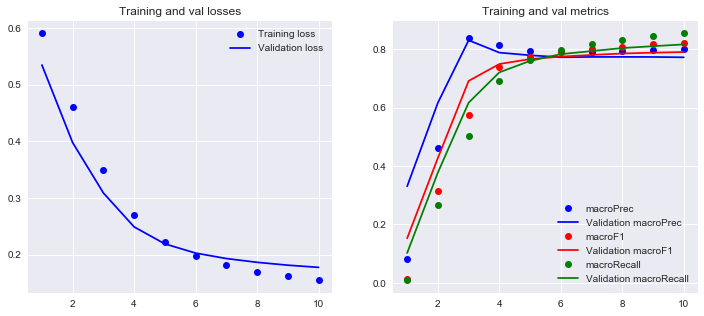

In [31]:
model4.plot()

### Comment
And the winner (marginally) is the average of the previous two loss functions, which is better than any of the two. At least on the 10-epoch stretch. It still goes up to almost 70% macro F1 on the validation set after just 3 epochs, and reaches 79% after the 10th epoch. Recall that our final macro-F1 on test data reached by the SVM was 80%. We do not want to look at test data just yet, but it seems that we have reproduced the result of a shallow classifier with a 50dim embedding, global averaging, and a single softmax-layer.

In [ ]:
# the history may be loaded from file and played with later 
# hist = json.load(open(os.path.join("my_embeddings", "history_of_50dim_GlblAvg_MyLoss_10epochs.p"), "r"))
# plot_history(hist)

---


### End